Load toolboxes:

In [1]:
from src import helper
from src import plot_settings

# import packages
import pymaid
import navis
import pickle
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import ks_2samp, linregress, lognorm, pearsonr, ttest_ind, mannwhitneyu
from itertools import combinations
from collections import Counter
from tqdm import tqdm

path_plots = 'plots/'

# Set matplotlib style
plt.rcParams.update(plot_settings.params)

### Load the required data from the server:

In [2]:
# load the remote instance of pymaid to the server
l1em = pymaid.connect_catmaid(server="https://l1em.catmaid.virtualflybrain.org/", api_token=None, max_threads=50, caching=False)    # L1 Larval CNS
l3vnc = pymaid.connect_catmaid(server="https://l3vnc.catmaid.virtualflybrain.org/", api_token=None, max_threads=50, caching=False, project_id=2)  # L3 Larval VNC

neurons_str = 'Gerhard et al. 2017'

# load neurons
# l1_neurons = pymaid.get_neurons('annotations:' + neurons_str, remote_instance=l1em)
l1_neurons = helper.try_with_retries(pymaid.get_neurons, 5, 'annotations:' + neurons_str, remote_instance=l1em)
l1_neurons.set_neuron_attributes(neurons_str, 'annotation')
# l3_neurons = pymaid.get_neurons('annotations:' + neurons_str, remote_instance=l3vnc)
l3_neurons = helper.try_with_retries(pymaid.get_neurons, 5, 'annotations:' + neurons_str, remote_instance=l3vnc)
l3_neurons.set_neuron_attributes(neurons_str, 'annotation')

# replace ' ' in all the names with '_' to match the names in the database
for neuron in l1_neurons:
    neuron.name = '_'.join(neuron.name.replace(' ', '_').split('_')[:2])
for neuron in l3_neurons:
    neuron.name = '_'.join(neuron.name.replace(' ', '_').split('_')[:2])

# filter out neurons without 'a1' or 'a3' in the name
for neuron in l1_neurons:
    if 'a1' not in neuron.name:
        l1_neurons -= neuron
for neuron in l3_neurons:
    if 'a3' not in neuron.name:
        l3_neurons -= neuron

INFO  : Global CATMAID instance set. Caching is OFF. (pymaid)
INFO  : Global CATMAID instance set. Caching is OFF. (pymaid)


Fetch neurons:   0%|          | 0/55 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/55 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/18 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/18 [00:00<?, ?it/s]

Organise the neuron cell types:

In [3]:
# Get mdIV (ddaC, v'ada and vdaB) neurons in L1 and L3
l1_ddaC_neurons = helper.filter_neurons(l1_neurons, 'ddaC')
l1_vada_neurons = helper.filter_neurons(l1_neurons, 'v\'ada')
l1_vdaB_neurons = helper.filter_neurons(l1_neurons, 'vdaB')
l3_ddaC_neurons = helper.filter_neurons(l3_neurons, 'ddaC')
l3_vada_neurons = helper.filter_neurons(l3_neurons, 'v\'ada')
l3_vdaB_neurons = helper.filter_neurons(l3_neurons, 'vdaB')

l1_mdIV_neurons = l1_ddaC_neurons + l1_vada_neurons + l1_vdaB_neurons
l3_mdIV_neurons = l3_ddaC_neurons + l3_vada_neurons + l3_vdaB_neurons

# Get LNs (A02n, A09a, A09c, A09l, A10a) neurons in L1 and L3
l1_A02n_neurons = helper.filter_neurons(l1_neurons, 'A02n')
l1_A02m_neurons = helper.filter_neurons(l1_neurons, 'A02m')
l1_A09a_neurons = helper.filter_neurons(l1_neurons, 'A09a')
l1_A09c_neurons = helper.filter_neurons(l1_neurons, 'A09c')
l1_A09l_neurons = helper.filter_neurons(l1_neurons, 'A09l')
l1_A10a_neurons = helper.filter_neurons(l1_neurons, 'A10a')

l3_A02n_neurons = helper.filter_neurons(l3_neurons, 'A02n')
l3_A02m_neurons = helper.filter_neurons(l3_neurons, 'A02m')
l3_A09a_neurons = helper.filter_neurons(l3_neurons, 'A09a')
l3_A09c_neurons = helper.filter_neurons(l3_neurons, 'A09c')
l3_A09l_neurons = helper.filter_neurons(l3_neurons, 'A09l')
l3_A10a_neurons = helper.filter_neurons(l3_neurons, 'A10a')

l1_LN_neurons = l1_A02n_neurons + l1_A02m_neurons + l1_A09a_neurons + l1_A09c_neurons + l1_A09l_neurons + l1_A10a_neurons
l3_LN_neurons = l3_A02n_neurons + l3_A02m_neurons + l3_A09a_neurons + l3_A09c_neurons + l3_A09l_neurons + l3_A10a_neurons

# sort all the neurons by name (left to right)
for neuron in [l1_ddaC_neurons, l1_vada_neurons, l1_vdaB_neurons, l3_ddaC_neurons, l3_vada_neurons, l3_vdaB_neurons,    # mdIVs
                l1_A02n_neurons, l1_A09a_neurons, l1_A09c_neurons, l1_A09l_neurons, l1_A10a_neurons, l3_A02n_neurons, l3_A09a_neurons, l3_A09c_neurons, l3_A09l_neurons, l3_A10a_neurons, # LNs
                l1_mdIV_neurons, l3_mdIV_neurons, l1_LN_neurons, l3_LN_neurons,
                ]:
    neuron.sort_values(key='name', ascending=True)

# create color dictionary for the neurons
for source_name in l1_mdIV_neurons.name:
    plot_settings.neuron_dict[source_name] = plot_settings.neuron_dict[source_name.split('_')[0]]
for target_name in l1_LN_neurons.name:
    plot_settings.neuron_dict[target_name] = plot_settings.neuron_dict[target_name.split('_')[0]]
# create color dictionary for the neurons
for source_name in l3_mdIV_neurons.name:
    plot_settings.neuron_dict[source_name] = plot_settings.neuron_dict[source_name.split('_')[0]]
for target_name in l3_LN_neurons.name:
    plot_settings.neuron_dict[target_name] = plot_settings.neuron_dict[target_name.split('_')[0]]

In [4]:
###########################################################
# Actual synapses
# l1_connectors = pymaid.get_connectors_between(l1_mdIV_neurons, l1_LN_neurons, remote_instance=l1em)
l1_connectors = helper.try_with_retries(pymaid.get_connectors_between, 5, l1_mdIV_neurons, l1_LN_neurons, remote_instance=l1em)
# l3_connectors = pymaid.get_connectors_between(l3_mdIV_neurons, l3_LN_neurons, remote_instance=l3vnc)
l3_connectors = helper.try_with_retries(pymaid.get_connectors_between, 5, l3_mdIV_neurons, l3_LN_neurons, remote_instance=l3vnc)

# add name tags of source and target neurons
l1_connectors['source_name'] = [l1_mdIV_neurons[l1_mdIV_neurons.skeleton_id == str(id)].name[0] for id in l1_connectors.source_neuron]
l1_connectors['target_name'] = [l1_LN_neurons[l1_LN_neurons.skeleton_id == str(id)].name[0] for id in l1_connectors.target_neuron]
l3_connectors['source_name'] = [l3_mdIV_neurons[l3_mdIV_neurons.skeleton_id == str(id)].name[0] for id in l3_connectors.source_neuron]
l3_connectors['target_name'] = [l3_LN_neurons[l3_LN_neurons.skeleton_id == str(id)].name[0] for id in l3_connectors.target_neuron]

###########################################################
# Splitted neurons
# l1_split_all = navis.morpho.split_axon_dendrite(l1_LN_neurons, reroot_soma=True, cellbodyfiber='soma')
l1_split_all = helper.try_with_retries(navis.morpho.split_axon_dendrite, 5, l1_LN_neurons, reroot_soma=True, cellbodyfiber='soma')
# l3_split_all = navis.morpho.split_axon_dendrite(l3_LN_neurons, reroot_soma=True, cellbodyfiber='soma')
l3_split_all = helper.try_with_retries(navis.morpho.split_axon_dendrite, 5, l3_LN_neurons, reroot_soma=True, cellbodyfiber='soma')

l1_LN_axon = l1_split_all[l1_split_all.compartment == 'axon']
l1_LN_dendrite = l1_split_all[l1_split_all.compartment == 'dendrite']
l1_LN_rest = l1_split_all[(l1_split_all.compartment != 'axon') & (l1_split_all.compartment != 'dendrite')]

l3_LN_axon = l3_split_all[l3_split_all.compartment == 'axon']
l3_LN_dendrite = l3_split_all[l3_split_all.compartment == 'dendrite']
l3_LN_rest = l3_split_all[(l3_split_all.compartment != 'axon') & (l3_split_all.compartment != 'dendrite')]

Splitting:   0%|          | 0/12 [00:00<?, ?it/s]

Splitting:   0%|          | 0/12 [00:00<?, ?it/s]

Load quantified PSD areas:

In [5]:
# load the areas dataframe
with open('l1_PSD_areas.pkl', 'rb') as f:
    l1_PSD_areas = pickle.load(f)

# load the areas dataframe
with open('l3_PSD_areas.pkl', 'rb') as f:
    l3_PSD_areas = pickle.load(f)

l3_PSD_areas

,pre_skeleton_id,pre_treenode_id,connector_id,post_treenode_id,post_skeleton_id,area,node2_id
0,189519,20187,20189,20209,1591487,7218.498551,20230
0,189519,20187,20189,20230,406883,65542.067786,20216
0,189519,20187,20189,20216,1771441,19115.920626,20209
0,1591477,22366,22368,22352,1591487,42049.376593,22352
0,1870224,25546,25548,25554,1725730,32317.223638,25554
...,...,...,...,...,...,...,...
0,1591468,379255,1942071,1662763,1591495,11644.305910,1662763
0,1591468,432794,1942332,1063836,1591495,6876.883835,1063836
0,1591477,1477508,1944587,1944584,1771441,40699.263325,1944584
0,1591472,206467,1945278,1945276,1771441,19401.727984,1945276


In [6]:
l1_connectors['area'] = [
    l1_PSD_areas[(l1_PSD_areas.connector_id == c_id) & (l1_PSD_areas.node2_id == n2_id)]['area'].values[0]
    for c_id, n2_id in l1_connectors[['connector_id', 'node2_id']].values
]
# add node2_loc from l1_actual_synapses table
l1_connectors['x'] = [l1_connectors.node2_loc[l1_connectors.node2_id == n_id].values[0][0] for n_id in l1_connectors['node2_id']]
l1_connectors['y'] = [l1_connectors.node2_loc[l1_connectors.node2_id == n_id].values[0][1] for n_id in l1_connectors['node2_id']]
l1_connectors['z'] = [l1_connectors.node2_loc[l1_connectors.node2_id == n_id].values[0][2] for n_id in l1_connectors['node2_id']]

l3_connectors['area'] = [
    l3_PSD_areas[(l3_PSD_areas.connector_id == c_id) & (l3_PSD_areas.node2_id == n2_id)]['area'].values[0]
    for c_id, n2_id in l3_connectors[['connector_id', 'node2_id']].values
]
# add node2_loc from l1_actual_synapses table
l3_connectors['x'] = [l3_connectors.node2_loc[l3_connectors.node2_id == n_id].values[0][0] for n_id in l3_connectors['node2_id']]
l3_connectors['y'] = [l3_connectors.node2_loc[l3_connectors.node2_id == n_id].values[0][1] for n_id in l3_connectors['node2_id']]
l3_connectors['z'] = [l3_connectors.node2_loc[l3_connectors.node2_id == n_id].values[0][2] for n_id in l3_connectors['node2_id']]

l3_connectors

,connector_id,connector_loc,node1_id,source_neuron,confidence1,creator1,node1_loc,node2_id,target_neuron,confidence2,creator2,node2_loc,source_name,target_name,area,x,y,z
0,20189,"[71493.2, 59988.6, 71600.0]",20187,189519,5,NaN,"[71495.5, 60165.7, 71600.0]",20209,1591487,5,NaN,"[71605.9, 59714.9, 71500.0]",ddaC_a3l,A09l_a3r,19115.920626,71605.9,59714.9,71500.0
1,20189,"[71493.2, 59988.6, 71600.0]",20187,189519,5,NaN,"[71495.5, 60165.7, 71600.0]",20216,1771441,5,NaN,"[71688.7, 59781.6, 71450.0]",ddaC_a3l,A09a_a3r,65542.067786,71688.7,59781.6,71450.0
2,20189,"[71493.2, 59988.6, 71600.0]",20187,189519,5,NaN,"[71495.5, 60165.7, 71600.0]",20230,406883,5,NaN,"[71916.4, 59786.2, 71250.0]",ddaC_a3l,A02m_a3l,7218.498551,71916.4,59786.2,71250.0
3,406621,"[58783.4, 59645.9, 61500.0]",406620,189519,5,NaN,"[58630.4, 59873.6, 61500.0]",406627,1078668,5,NaN,"[58817.9, 59567.7, 61500.0]",ddaC_a3l,A02n_a3l,23400.226535,58817.9,59567.7,61500.0
4,406814,"[59077.8, 59609.1, 69100.0]",406813,189519,5,NaN,"[59095.1, 59728.7, 69100.0]",406820,1584165,5,NaN,"[58928.3, 59567.7, 69100.0]",ddaC_a3l,A10a_a3r,7869.036790,58928.3,59567.7,69100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,1930834,"[61212.2, 58696.0, 71250.0]",1021586,1870224,5,NaN,"[61260.1, 59050.2, 71250.0]",1862720,1725730,5,NaN,"[61384.7, 58581.0, 71250.0]",vdaB_a3r,A09c_a3l,36710.339803,61384.7,58581.0,71250.0
1558,1931020,"[69549.7, 58371.7, 75200.0]",1022088,1870224,5,NaN,"[69488.8, 58548.8, 75150.0]",1425060,1725730,5,NaN,"[69556.6, 58245.2, 75200.0]",vdaB_a3r,A09c_a3l,38264.532445,69556.6,58245.2,75200.0
1559,1940337,"[59805.8, 61659.7, 70250.0]",1390529,1870224,5,NaN,"[60141.9, 61857.7, 70250.0]",1133937,1725730,5,NaN,"[59636.7, 61545.7, 70250.0]",vdaB_a3r,A09c_a3l,52764.107474,59636.7,61545.7,70250.0
1560,1940337,"[59805.8, 61659.7, 70250.0]",1390529,1870224,5,NaN,"[60141.9, 61857.7, 70250.0]",537233,1584165,5,NaN,"[59924.2, 61459.4, 70250.0]",vdaB_a3r,A10a_a3r,16815.920626,59924.2,61459.4,70250.0


In [7]:
l1_median_area = (l1_PSD_areas['area']/100_000).median()
l3_median_area = (l3_PSD_areas['area']/100_000).median()
l3_median_area / l1_median_area

0.8057202938985757

## Figure 2

### Figure 2 panel B:

p-value (before scaling): 1.8227298645948537e-05
p-value (after scaling by 0.8057202938985756): 0.6669958352756998


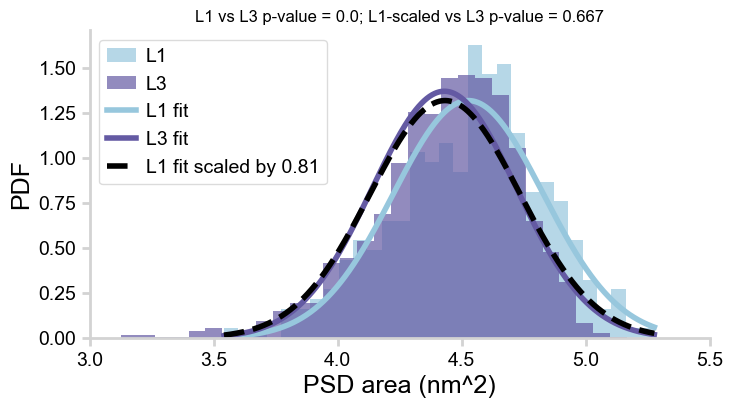

In [ ]:
# Now perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(l1_PSD_areas['area'], l3_PSD_areas['area'])
print(f"p-value (before scaling): {p_value}")

# Rescale l1_PSD_areas by a scalar and repeat the test
l1_median_area = (l1_PSD_areas['area']).median()
l3_median_area = (l3_PSD_areas['area']).median()
scaling_factor = l3_median_area / l1_median_area # Adjust this scalar to fit distributions
l1_scaled = l1_PSD_areas['area'] * scaling_factor

# Perform the KS test after rescaling
ks_statistic_scaled, p_value_scaled = ks_2samp(l1_scaled, l3_PSD_areas['area'])
print(f"p-value (after scaling by {scaling_factor}): {p_value_scaled}")

# Plot the histograms with the scaling applied
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

# Original data
np.log10(l1_PSD_areas['area']).plot.hist(bins=30, ax=ax1, density=True, alpha=0.7, color=plot_settings.l1_color, label='L1')
np.log10(l3_PSD_areas['area']).plot.hist(bins=30, ax=ax1, density=True, alpha=0.7, color=plot_settings.l3_color, label='L3')

# Fit lognormal distribution to the scaled data
params_scaled = lognorm.fit(np.log10(l1_scaled))
params1 = lognorm.fit(np.log10(l1_PSD_areas['area']))
params2 = lognorm.fit(np.log10(l3_PSD_areas['area']))

# Generate PDF values for the fitted distributions
x = np.linspace(min(np.log10(l1_PSD_areas['area'])), max(np.log10(l1_PSD_areas['area'])), 1000)
pdf_scaled = lognorm.pdf(x, *params_scaled)
pdf1 = lognorm.pdf(x, *params1)
pdf2 = lognorm.pdf(x, *params2)

# Plot fitted distributions
ax1.plot(x, pdf1, color=plot_settings.l1_color, lw=4, label='L1 fit')
ax1.plot(x, pdf2, plot_settings.l3_color, lw=4, label='L3 fit')
ax1.plot(x, pdf_scaled, color='k', lw=4, linestyle='--', label=f'L1 fit scaled by {scaling_factor:.2f}')

# Set labels and legends
ax1.set_xlabel('PSD area (nm^2)')
ax1.set_ylabel('PDF')
ax1.set_title(f'L1 vs L3 p-value = {round(p_value, 4)}; L1-scaled vs L3 p-value = {round(p_value_scaled, 4)}')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# Change x tick labels to the actual values, thus trnasform the log values back to normal
# First change x position as if it was a log scale using major formatter
min_value = min(l1_PSD_areas['area'].min(), l3_PSD_areas['area'].min())
max_value = max(l1_PSD_areas['area'].max(), l3_PSD_areas['area'].max())

# ax1.set_xticklabels([f'{10**tick:.2f}' for tick in ax1.get_xticks()])
ax1.set_xlim((3, 5.5))
ax1.legend()

# plt.savefig(path_plots+'Fig2/'+'Fig2B.png')
# plt.savefig(path_plots+'Fig2/'+'Fig2B.svg')

### Figure 2 panel D:

In [9]:
l1_splits = []
for neuron in tqdm(l1_LN_neurons):
    root_ids = neuron.nodes[neuron.nodes['type'] == 'root']['node_id'].tolist()
    parents_list = neuron.nodes['parent_id'].tolist()
    parents_list_filtered = [parent for parent in parents_list if parent not in root_ids]
    counts = Counter(parents_list_filtered)
    junctions_list = [item for item, count in counts.items() if count > 1]

    # splits = navis.cut_skeleton(neuron, junctions_list)
    splits = helper.try_with_retries(navis.cut_skeleton, 5, neuron, junctions_list)
    l1_splits.append(splits)

100%|██████████| 12/12 [11:03<00:00, 55.30s/it]


In [10]:
l3_splits = []
for neuron in tqdm(l3_LN_neurons):
    root_ids = neuron.nodes[neuron.nodes['type'] == 'root']['node_id'].tolist()
    parents_list = neuron.nodes['parent_id'].tolist()
    parents_list_filtered = [parent for parent in parents_list if parent not in root_ids]
    counts = Counter(parents_list_filtered)
    junctions_list = [item for item, count in counts.items() if count > 1]

    # splits = navis.cut_skeleton(neuron, junctions_list)
    splits = helper.try_with_retries(navis.cut_skeleton, 5, neuron, junctions_list)
    l3_splits.append(splits)

100%|██████████| 12/12 [37:19<00:00, 186.63s/it]


In [11]:
for splited_neuron in l1_splits:
    for i, split in enumerate(splited_neuron):
        matching_connectors = split.connectors['connector_id'].values
        matching_node_ids = split.connectors['node_id'].values
        l1_PSD_areas.loc[
            (l1_PSD_areas['connector_id'].isin(matching_connectors)) & 
            (l1_PSD_areas['node2_id'].isin(matching_node_ids)),
            'split_id'
        ] = i + 1

for splited_neuron in l3_splits:
    for i, split in enumerate(splited_neuron):
        matching_connectors = split.connectors['connector_id'].values
        matching_node_ids = split.connectors['node_id'].values
        l3_PSD_areas.loc[
            (l3_PSD_areas['connector_id'].isin(matching_connectors)) & 
            (l3_PSD_areas['node2_id'].isin(matching_node_ids)),
            'split_id'
        ] = i + 1

In [12]:
# Prepare which dataframes are going to be used
area_mappings = {
    'l1': l1_PSD_areas,
    'l3' : l3_PSD_areas,
}

connectors_mappings = {
    'l1': l1_connectors,
    'l3' : l3_connectors,
}
# Decide which data to analyse
dataset_list = ['l1', 'l3']

PSD_areas_list = [area_mappings[dataset].copy() for dataset in dataset_list]
PSD_areas_sh_list = [area_mappings[dataset].assign(area=np.random.permutation(area_mappings[dataset]['area'])) for dataset in dataset_list]
connectors_list  = [connectors_mappings[dataset].copy() for dataset in dataset_list]

In [13]:
# Collect dataframes and its shuffled versions in lists, where they have been paired by pre-post ids and already calculates the CV and means
np.random.seed(42)

all_grouped_pairs_list = []
all_grouped_pairs_shuffled_list = []
all
for dataset, PSD_areas, PSD_areas_shuffled in zip(dataset_list, PSD_areas_list, PSD_areas_sh_list):

    all_groups = []
    all_groups_shuffled = []
    all_groups.append(PSD_areas.groupby(['pre_skeleton_id', 'post_skeleton_id']))
    all_groups_shuffled.append(PSD_areas_shuffled.groupby(['pre_skeleton_id', 'post_skeleton_id']))
    
    all_grouped_pairs = pd.DataFrame([])

    for group in all_groups:
        for (pre_id, post_id), pair in group:
            if len(pair) > 1:
                all_grouped_pairs = pd.concat([all_grouped_pairs, pd.DataFrame({
                    'pre_skeleton_id': [pre_id],
                    'post_skeleton_id': [post_id],
                    'mean_area': [pair.area.mean()],
                    'std': [pair.area.std()],
                    'CV': [pair.area.std() / pair.area.mean()],
                    'num_synapses': [len(pair)]
                })], ignore_index=True)

    all_grouped_pairs_shuffled = pd.DataFrame([])

    for group in all_groups_shuffled:
        for (pre_id, post_id), pair in group:
            if len(pair) > 1:
                all_grouped_pairs_shuffled = pd.concat([all_grouped_pairs_shuffled, pd.DataFrame({
                    'pre_skeleton_id': [pre_id],
                    'post_skeleton_id': [post_id],
                    'mean_area': [pair.area.mean()],
                    'std': [pair.area.std()],
                    'CV': [pair.area.std() / pair.area.mean()],
                    'num_synapses': [len(pair)]
                })], ignore_index=True)

    # Find the maximum and minimum number of synapses for each post_skeleton_id
    max_synapses = all_grouped_pairs.groupby('post_skeleton_id')['num_synapses'].max().reset_index()
    max_synapses = max_synapses.rename(columns={'num_synapses': 'max_num_synapses'})
    min_synapses = all_grouped_pairs.groupby('post_skeleton_id')['num_synapses'].min().reset_index()
    min_synapses = min_synapses.rename(columns={'num_synapses': 'min_num_synapses'})

    # Merge the maximum and minimum number of synapses back into the original DataFrame
    all_grouped_pairs = all_grouped_pairs.merge(max_synapses, on='post_skeleton_id')
    all_grouped_pairs = all_grouped_pairs.merge(min_synapses, on='post_skeleton_id')

    # Create the 'preferential' and 'least_preferential' columns
    all_grouped_pairs['preferential'] = all_grouped_pairs['num_synapses'] == all_grouped_pairs['max_num_synapses']
    all_grouped_pairs['least_preferential'] = all_grouped_pairs['num_synapses'] == all_grouped_pairs['min_num_synapses']

    # Drop the 'max_num_synapses' and 'min_num_synapses' columns as they're no longer needed
    all_grouped_pairs = all_grouped_pairs.drop(columns=['max_num_synapses', 'min_num_synapses'])

    all_grouped_pairs_list.append(all_grouped_pairs)
    all_grouped_pairs_shuffled_list.append(all_grouped_pairs_shuffled)

# Get the indices where 'preferential' and 'least_preferential' are True for L1 and L3
highlight_indices_l1_preferential = all_grouped_pairs_list[0][all_grouped_pairs_list[0]['preferential'] == True].index
highlight_indices_l3_preferential = all_grouped_pairs_list[1][all_grouped_pairs_list[1]['preferential'] == True].index

highlight_indices_l1_least_preferential = all_grouped_pairs_list[0][all_grouped_pairs_list[0]['least_preferential'] == True].index
highlight_indices_l3_least_preferential = all_grouped_pairs_list[1][all_grouped_pairs_list[1]['least_preferential'] == True].index

l1_connections = all_grouped_pairs_list[0]
l3_connections = all_grouped_pairs_list[1]

# Replace the skeleton ids by the neuron names
l1_connections['pre_name'] = [l1_mdIV_neurons[l1_mdIV_neurons.skeleton_id.astype(np.uint32) == sk_id].name[0] for sk_id in l1_connections['pre_skeleton_id']]
l1_connections['post_name'] = [l1_LN_neurons[l1_LN_neurons.skeleton_id.astype(np.uint32) == sk_id].name[0] for sk_id in l1_connections['post_skeleton_id']]
l3_connections['pre_name'] = [l3_mdIV_neurons[l3_mdIV_neurons.skeleton_id.astype(np.uint32) == sk_id].name[0] for sk_id in l3_connections['pre_skeleton_id']]
l3_connections['post_name'] = [l3_LN_neurons[l3_LN_neurons.skeleton_id.astype(np.uint32) == sk_id].name[0] for sk_id in l3_connections['post_skeleton_id']]

# Sort by Post neuron name and then by number of synapses, and reindex
l1_connections = l1_connections.sort_values(by=['post_name', 'num_synapses']).reset_index(drop=True)
l3_connections = l3_connections.sort_values(by=['post_name', 'num_synapses']).reset_index(drop=True)
l1_connections = l1_connections.sort_values(by=['post_name', 'CV']).reset_index(drop=True)
l3_connections = l3_connections.sort_values(by=['post_name', 'CV']).reset_index(drop=True)

# replace the pre_name with the rank of connection. meaning for each post neuron, rank the pre neurons by the number of synapses
l1_connections['rank'] = l1_connections.groupby('post_name')['num_synapses'].rank(ascending=False, method='first')
l3_connections['rank'] = l3_connections.groupby('post_name')['num_synapses'].rank(ascending=False, method='first')

l1_connections = l1_connections.sort_values(by='rank')
l3_connections = l3_connections.sort_values(by='rank')

l1_rank_mean = l1_connections.groupby('rank')['num_synapses'].mean()
l3_rank_mean = l3_connections.groupby('rank')['num_synapses'].mean()

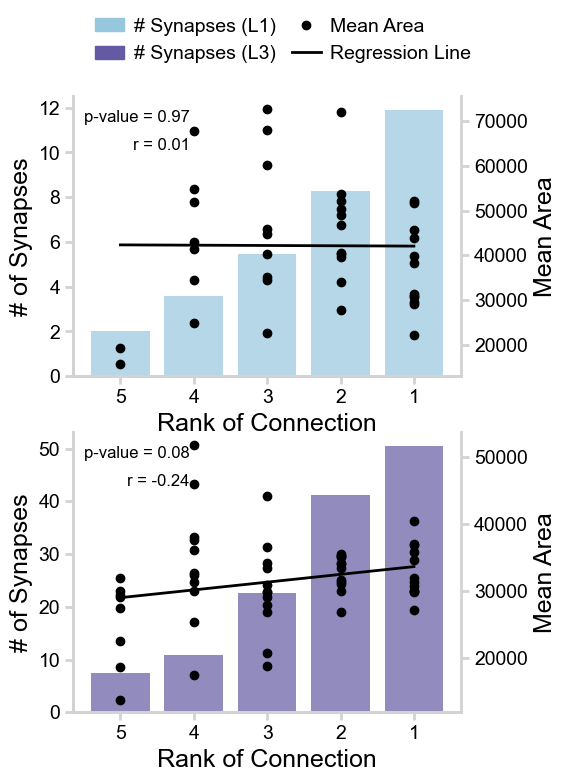

In [15]:
# Figure size: 90 mm wide (~3.54 in) x 2.8 in height
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(5, 8))
ax1x = ax1.twinx()
ax2x = ax2.twinx()

# Plot the number of synapses on the left y-axis, with bars for each rank
bars1 = ax1.bar(l1_rank_mean.index, l1_rank_mean.values, color=plot_settings.l1_color, alpha=0.7, label='# of Synapses')
bars2 = ax2.bar(l3_rank_mean.index, l3_rank_mean.values, color=plot_settings.l3_color, alpha=0.7, label='# of Synapses')

# Plot the mean synapse area on the right y-axis, with a line for each rank
scatter1 = ax1x.scatter(l1_connections['rank'], l1_connections['mean_area'], color='k', marker='o', label='Mean Area')
scatter2 = ax2x.scatter(l3_connections['rank'], l3_connections['mean_area'], color='k', marker='o', label='Mean Area')

# fit a linear regression line to the data
slope_l1, intercept_l1, r_value_l1, p_value_l1, std_err_l1 = linregress(l1_connections['rank'], l1_connections['mean_area'])
slope_l3, intercept_l3, r_value_l3, p_value_l3, std_err_l3 = linregress(l3_connections['rank'], l3_connections['mean_area'])

# Plot the regression line
line1 = ax1x.plot(l1_connections['rank'], slope_l1 * l1_connections['rank'] + intercept_l1, color='k', label='Regression line')
line2 = ax2x.plot(l3_connections['rank'], slope_l3 * l3_connections['rank'] + intercept_l3, color='k', label='Regression line')

# Add text for the r and p value
ax1x.text(0.3, 0.85, f'r = {r_value_l1:.2f}', transform=ax1x.transAxes, ha='right', va='top', fontsize=12, color='black')
ax1x.text(0.3, 0.95, f'p-value = {p_value_l1:.2f}', transform=ax1x.transAxes, ha='right', va='top', fontsize=12, color='black')

ax2x.text(0.3, 0.85, f'r = {r_value_l3:.2f}', transform=ax2x.transAxes, ha='right', va='top', fontsize=12, color='black')
ax2x.text(0.3, 0.95, f'p-value = {p_value_l3:.2f}', transform=ax2x.transAxes, ha='right', va='top', fontsize=12, color='black')

# invert the x-axis
ax1.invert_xaxis()
ax2.invert_xaxis()

# Add right spine
ax1.spines["right"].set_visible(True)
ax2.spines["right"].set_visible(True)

# Add labels
ax1.set_ylabel('# of Synapses')
ax1x.set_ylabel('Mean Area')
ax1.set_xlabel('Rank of Connection')
ax2.set_ylabel('# of Synapses')
ax2x.set_ylabel('Mean Area')
ax2.set_xlabel('Rank of Connection')

# Create custom legend handles
bar_patch1 = mpatches.Patch(color='#97c7dd', label='# Synapses (L1)')
bar_patch2 = mpatches.Patch(color='#645aa3', label='# Synapses (L3)')
scatter_handle = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=6, label='Mean Area')
line_handle = mlines.Line2D([], [], color='k', label='Regression Line')

# Combine handles into a single legend
handles = [bar_patch1, bar_patch2, scatter_handle, line_handle]
labels = [h.get_label() for h in handles]
fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)

# plt.tight_layout()

# Save the figure
fig.savefig(path_plots+'Fig2/Fig2D', bbox_inches='tight')
fig.savefig(path_plots+'Fig2/Fig2D.svg', bbox_inches='tight')

### Figure 2 panel F:

In [ ]:
all_grouped_pairs_const_list = []
all_grouped_pairs_const_shuffled_list = []

# Loop through the datasets
for dataset, PSD_areas, PSD_areas_shuffled in zip(dataset_list, PSD_areas_list, PSD_areas_sh_list):
    
    all_groups = []
    all_groups_shuffled = []

    # Group by 'pre_skeleton_id', 'post_skeleton_id', and 'split_id'
    all_groups.append(PSD_areas.groupby(['pre_skeleton_id', 'post_skeleton_id', 'split_id']))
    all_groups_shuffled.append(PSD_areas_shuffled.groupby(['pre_skeleton_id', 'post_skeleton_id', 'split_id']))

    all_grouped_pairs = pd.DataFrame([])

    # Process the grouped PSD_areas
    for group in all_groups:
        for (pre_id, post_id, split_id), pair in group:
            if len(pair) > 1:
                all_grouped_pairs = pd.concat([
                    all_grouped_pairs,
                    pd.DataFrame({
                        'pre_skeleton_id': [pre_id],
                        'post_skeleton_id': [post_id],
                        'split_id': [split_id],  # Include split_id in the output
                        'mean_area': [pair.area.mean()],
                        'std': [pair.area.std()],
                        'CV': [pair.area.std() / pair.area.mean() if pair.area.mean() != 0 else 0],  # Avoid division by zero
                        'num_synapses': [len(pair)]
                    })
                ], ignore_index=True)

    all_grouped_pairs_shuffled = pd.DataFrame([])

    # Process the grouped PSD_areas_shuffled
    for group in all_groups_shuffled:
        for (pre_id, post_id, split_id), pair in group:
            if len(pair) > 1:
                all_grouped_pairs_shuffled = pd.concat([
                    all_grouped_pairs_shuffled,
                    pd.DataFrame({
                        'pre_skeleton_id': [pre_id],
                        'post_skeleton_id': [post_id],
                        'split_id': [split_id],  # Include split_id in the output
                        'mean_area': [pair.area.mean()],
                        'std': [pair.area.std()],
                        'CV': [pair.area.std() / pair.area.mean() if pair.area.mean() != 0 else 0],  # Avoid division by zero
                        'num_synapses': [len(pair)]
                    })
                ], ignore_index=True)

    # Append results to the lists
    all_grouped_pairs_const_list.append(all_grouped_pairs)
    all_grouped_pairs_const_shuffled_list.append(all_grouped_pairs_shuffled)

all_grouped_pairs_list = []
all_grouped_pairs_shuffled_list = []
for dataset, PSD_areas, PSD_areas_shuffled in zip(dataset_list, PSD_areas_list, PSD_areas_sh_list):


    all_groups = []
    all_groups_shuffled = []
    all_groups.append(PSD_areas.groupby(['pre_skeleton_id', 'post_skeleton_id']))
    all_groups_shuffled.append(PSD_areas_shuffled.groupby(['pre_skeleton_id', 'post_skeleton_id']))

    
    
    all_grouped_pairs = pd.DataFrame([])

    for group in all_groups:
        for (pre_id, post_id), pair in group:
            if len(pair) > 1:
                all_grouped_pairs = pd.concat([all_grouped_pairs, pd.DataFrame({
                    'pre_skeleton_id': [pre_id],
                    'post_skeleton_id': [post_id],
                    'mean_area': [pair.area.mean()],
                    'std': [pair.area.std()],
                    'CV': [pair.area.std() / pair.area.mean()],
                    'num_synapses': [len(pair)]
                })], ignore_index=True)

    all_grouped_pairs_shuffled = pd.DataFrame([])

    for group in all_groups_shuffled:
        for (pre_id, post_id), pair in group:
            if len(pair) > 1:
                all_grouped_pairs_shuffled = pd.concat([all_grouped_pairs_shuffled, pd.DataFrame({
                    'pre_skeleton_id': [pre_id],
                    'post_skeleton_id': [post_id],
                    'mean_area': [pair.area.mean()],
                    'std': [pair.area.std()],
                    'CV': [pair.area.std() / pair.area.mean()],
                    'num_synapses': [len(pair)]
                })], ignore_index=True)

    all_grouped_pairs_list.append(all_grouped_pairs)
    all_grouped_pairs_shuffled_list.append(all_grouped_pairs_shuffled)

# Split this dataframe into connections of different tuples (dual: 2 synapses, tri: 3, multi: 4 and more synapses)
dual_syn_pairs_const_list = []
multi_syn_pairs_const_list = []

for all_grouped_pairs in all_grouped_pairs_const_list:
    dual_index = all_grouped_pairs['num_synapses'] == 2
    multi_index = all_grouped_pairs['num_synapses'] > 3

    dual_syn_pairs_const_list.append(all_grouped_pairs[dual_index])
    multi_syn_pairs_const_list.append(all_grouped_pairs[multi_index])


dual_syn_pairs_const_shuffled_list = []
multi_syn_pairs_const_shuffled_list = []

for all_grouped_pairs_shuffled in all_grouped_pairs_const_shuffled_list:
    dual_index_shuffled = all_grouped_pairs_shuffled['num_synapses'] == 2
    multi_index_shuffled = all_grouped_pairs_shuffled['num_synapses'] > 3

    dual_syn_pairs_const_shuffled_list.append(all_grouped_pairs_shuffled[dual_index_shuffled])
    multi_syn_pairs_const_shuffled_list.append(all_grouped_pairs_shuffled[multi_index_shuffled])


dual_syn_pairs_list = []
multi_syn_pairs_list = []

for all_grouped_pairs in all_grouped_pairs_list:
    dual_index = all_grouped_pairs['num_synapses'] == 2
    multi_index = all_grouped_pairs['num_synapses'] > 3

    dual_syn_pairs_list.append(all_grouped_pairs[dual_index])
    multi_syn_pairs_list.append(all_grouped_pairs[multi_index])


dual_syn_pairs_shuffled_list = []
multi_syn_pairs_shuffled_list = []

for all_grouped_pairs_shuffled in all_grouped_pairs_shuffled_list:
    dual_index_shuffled = all_grouped_pairs_shuffled['num_synapses'] == 2
    multi_index_shuffled = all_grouped_pairs_shuffled['num_synapses'] > 3

    dual_syn_pairs_shuffled_list.append(all_grouped_pairs_shuffled[dual_index_shuffled])
    multi_syn_pairs_shuffled_list.append(all_grouped_pairs_shuffled[multi_index_shuffled])

data pairs:  0.15921368719624146 0.3465809417079291
R² to angle bisector: -0.5429302874149604


/opt/anaconda3/envs/connectome/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/connectome/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


mean shuffled dual:  -0.02031898094924771 0.52642500896719
structure pairs:  0.989081931458526 1.0599501547892287e-30
data pairs:  0.18886833554345744 0.013090541517195515
R² to angle bisector: -0.9059834345621014


/opt/anaconda3/envs/connectome/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/connectome/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


mean shuffled dual:  -2.1895217080338815e-05 0.5109143234668271
structure pairs:  0.9928124091722419 1.1308449223659565e-158


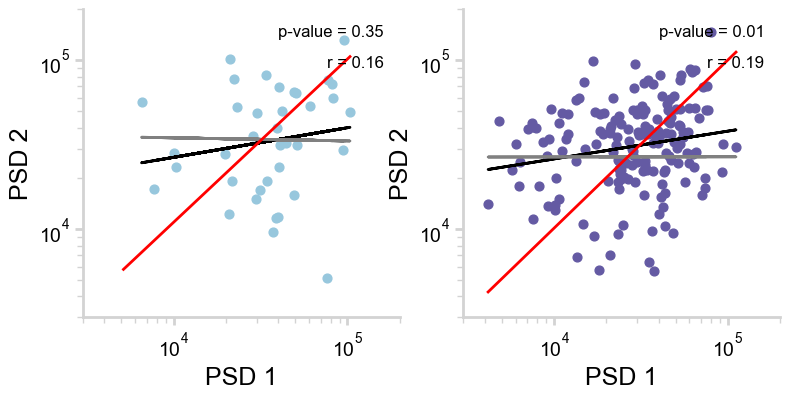

In [ ]:
bartol_flag = False

# Create a figure with two vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

for n, (df_pairs, df_pairs_shuffled, ax_1) in enumerate(zip(
                                                    dual_syn_pairs_const_list,
                                                    dual_syn_pairs_const_shuffled_list,
                                                    [ax1, ax2])):
    # Get the PSD areas for the current dataset
    df_PSD = PSD_areas_list[n]  # Original

    # Get pairs from dual synapse pairs
    pairs_from_dual = []
    for index, row in df_pairs.iterrows():
        pre_id = row['pre_skeleton_id']
        post_id = row['post_skeleton_id']
        split_id = row['split_id']
        filtered_df = df_PSD[(df_PSD['pre_skeleton_id'] == pre_id) & (df_PSD['post_skeleton_id'] == post_id) & (df_PSD['split_id'] == split_id)]
        list_areas = filtered_df['area'].tolist()
        pair = list(combinations(list_areas, 2))
        if bartol_flag:
            # For each pair in the dual synapse, make the first element the x and the second the y
            pair = [(max(x), min(x)) for x in pair]
        pairs_from_dual.extend(pair)
        
    # Separate x and y values for pairs and triplets
    x1, y1 = zip(*pairs_from_dual)

    # Scatter plot for pairs and triplets
    ax_1.scatter(x1, y1, color=plot_settings.l1_color if n==0  else plot_settings.l3_color, label='Pairs', s=40)

    # Log transform for regression analysis
    x1_log = np.log10(np.array(x1))
    y1_log = np.log10(np.array(y1))

    # Perform linear regression and plot the fitted line
    slope, intercept, r_value, p_value, std_err = linregress(x1_log, y1_log)
    y_fit_log = slope * x1_log + intercept
    print('data pairs: ' , r_value, p_value)

    # R-squared relative to y = x (angle bisector)
    ss_res = np.sum((y1_log - x1_log)**2)
    ss_tot = np.sum((y1_log - np.mean(y1_log))**2)
    r_squared_bisector = 1 - ss_res / ss_tot
    print('R² to angle bisector:', r_squared_bisector)

    # Calculate pears correlation coefficient
    # Add r and p values to the plot
    ax_1.text(0.95, 0.85, f'r = {r_value:.2f}', transform=ax_1.transAxes, ha='right', va='top', fontsize=12, color='black')
    ax_1.text(0.95, 0.95, f'p-value = {p_value:.2f}', transform=ax_1.transAxes, ha='right', va='top', fontsize=12, color='black')

    # Plot regression line in original scale
    ax_1.plot(10**x1_log, 10**y_fit_log, color='k')

    ### Shuffled data ###
    # Number of shuffling iterations
    n_iterations = 100  # Adjust as needed

    # Storage for regression parameters
    slopes_dual, intercepts_dual = [], []
    slopes_tri, intercepts_tri = [], []
    r_dual, p_dual = [], []

    for _ in range(n_iterations):
        # Shuffle area values
        df_PSD_shuffled = df_PSD.copy()
        df_PSD_shuffled['area'] = np.random.permutation(df_PSD_shuffled['area'].values)

        # Get shuffled pairs
        pairs_from_dual_shuffled = []
        for index, row in df_pairs_shuffled.iterrows():
            pre_id, post_id, split_id = row[['pre_skeleton_id', 'post_skeleton_id', 'split_id']]
            filtered_df = df_PSD_shuffled[(df_PSD_shuffled['pre_skeleton_id'] == pre_id) & 
                                        (df_PSD_shuffled['post_skeleton_id'] == post_id) & 
                                        (df_PSD_shuffled['split_id'] == split_id)]
            list_areas = filtered_df['area'].tolist()
            pair = list(combinations(list_areas, 2))
            if bartol_flag:
                # For each pair in the dual synapse, make the first element the x and the second the y
                # print(pair)
                pair = [(max(x), min(x)) for x in pair]
                # print(pair)
            pairs_from_dual_shuffled.extend(pair)

        # Convert to log scale
        x1_shuffled, y1_shuffled = zip(*pairs_from_dual_shuffled)
        x1_shuffled_log, y1_shuffled_log = np.log10(np.array(x1_shuffled)), np.log10(np.array(y1_shuffled))

        # Regression for dual synapse pairs
        slope, intercept, r, p, _ = linregress(x1_shuffled_log, y1_shuffled_log)
        slopes_dual.append(slope)
        intercepts_dual.append(intercept)
        r_dual.append(r)
        p_dual.append(p)

    # Compute the mean regression parameters
    mean_slope_dual, mean_intercept_dual, mean_r_dual, mean_p_dual = np.mean(slopes_dual), np.mean(intercepts_dual), np.mean(r_dual), np.mean(p_dual)
    mean_slope_tri, mean_intercept_tri = np.mean(slopes_tri), np.mean(intercepts_tri)

    print('mean shuffled dual: ', mean_r_dual, mean_p_dual)

    # Generate x-values for the regression lines (log scale)
    x_values_log = np.linspace(min(x1_shuffled_log), max(x1_shuffled_log), 100)

    # Compute mean regression lines
    y_fit_dual_log = mean_slope_dual * x1_log + mean_intercept_dual
    ax_1.plot(10**x1_log, 10**y_fit_dual_log, color='gray')

    ### Structured data ###
    # Flatten, sort, and reassign
    flattened_sorted = np.sort(np.array(pairs_from_dual).flatten())
    # Reshape into pairs: highest with second-highest, lowest with second-lowest
    N = len(pairs_from_dual)
    pairs_from_dual_structure =list(flattened_sorted.reshape(N, 2))

    # Separate x and y values for pairs and triplets
    x1_structure, y1_structure = zip(*pairs_from_dual_structure)

    # Log transform for regression analysis
    x1_structure_log = np.log10(np.array(x1_structure))
    y1_structure_log = np.log10(np.array(y1_structure))

    # Perform linear regression and plot the fitted line
    slope, intercept, r_value, p_value, std_err = linregress(x1_structure_log, y1_structure_log)
    y_fit_log = slope * x1_structure_log + intercept
    # Calculate pears correlation coefficient
    r, p = pearsonr(x1_structure, y1_structure)
    print('structure pairs: ', r, p)
    ax_1.plot(10**x1_structure_log, 10**y_fit_log, color='r')
    
    for ax in [ax_1]:
        # Add titles and labels
        # ax.set_title('L1' if n == 0 else 'L3')
        ax.set_xlabel('PSD 1')
        ax.set_ylabel('PSD 2')
        ax.set_xlim(3e3, 2e5)
        ax.set_ylim(3e3, 2e5)
        ax.set_xscale('log')
        ax.set_yscale('log')
        # ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        
# plt.savefig(path_plots+'Fig2/Fig2F.png')
# plt.savefig(path_plots+'Fig2/Fig2F.svg')

### Figure 2 panel G:

In [19]:
### Actual data ###
# Get the PSD areas for the current dataset
df_PSD_l1 = PSD_areas_list[0]
df_PSD_l3 = PSD_areas_list[1]

# Get pairs from dual synapse pairs
pairs_from_dual_l1 = []
for index, row in dual_syn_pairs_const_list[0].iterrows():
    pre_id, post_id, split_id = row[['pre_skeleton_id', 'post_skeleton_id', 'split_id']]
    filtered_df = df_PSD_l1[(df_PSD_l1['pre_skeleton_id'] == pre_id) & (df_PSD_l1['post_skeleton_id'] == post_id) & (df_PSD_l1['split_id'] == split_id)]
    list_areas = filtered_df['area'].tolist()
    pair = list(combinations(list_areas, 2))
    pairs_from_dual_l1.extend(pair)

pairs_from_dual_l3 = []
for index, row in dual_syn_pairs_const_list[1].iterrows():
    pre_id, post_id, split_id = row[['pre_skeleton_id', 'post_skeleton_id', 'split_id']]
    filtered_df = df_PSD_l3[(df_PSD_l3['pre_skeleton_id'] == pre_id) & (df_PSD_l3['post_skeleton_id'] == post_id) & (df_PSD_l3['split_id'] == split_id)]
    list_areas = filtered_df['area'].tolist()
    pair = list(combinations(list_areas, 2))
    pairs_from_dual_l3.extend(pair)

CV_l1 = np.std(np.array(pairs_from_dual_l1), axis=1) / np.mean(np.array(pairs_from_dual_l1), axis=1)
CV_l3 = np.std(np.array(pairs_from_dual_l3), axis=1) / np.mean(np.array(pairs_from_dual_l3), axis=1)

mean_CV_l1 = np.mean(CV_l1)
std_CV_L1 = np.std(CV_l1)
mean_CV_l3 = np.mean(CV_l3)
std_CV_L3 = np.std(CV_l3)

### Structured data ###
# Flatten, sort, and reassign
flattened_sorted_l1 = np.sort(np.array(pairs_from_dual_l1).flatten())
# Reshape into pairs: highest with second-highest, lowest with second-lowest
N = len(pairs_from_dual_l1)
pairs_from_dual_structure_l1 =list(flattened_sorted_l1.reshape(N, 2))

flattened_sorted_l3 = np.sort(np.array(pairs_from_dual_l3).flatten())
N = len(pairs_from_dual_l3)
pairs_from_dual_structure_l3 = list(flattened_sorted_l3.reshape(N, 2))

CV_structure_l1 = np.std(np.array(pairs_from_dual_structure_l1), axis=1) / np.mean(np.array(pairs_from_dual_structure_l1), axis=1)
CV_structure_l3 = np.std(np.array(pairs_from_dual_structure_l3), axis=1) / np.mean(np.array(pairs_from_dual_structure_l3), axis=1)

mean_CV_structure_l1 = np.mean(CV_structure_l1)
mean_CV_structure_l3 = np.mean(CV_structure_l3)
std_CV_structure_l1 = np.std(CV_structure_l1)
std_CV_structure_l3 = np.std(CV_structure_l3)

### Shuffled data ###
# Number of shuffling iterations
n_iterations = 100  # Adjust as needed

# Storage for regression parameters
l1_shuffled_CVs = []
l3_shuffled_CVs = []

for _ in range(n_iterations):
    # Shuffle area values
    df_PSD_shuffled_l1 = PSD_areas_list[0].copy()
    df_PSD_shuffled_l3 = PSD_areas_list[1].copy()
    df_PSD_shuffled_l1['area'] = np.random.permutation(df_PSD_shuffled_l1['area'].values)
    df_PSD_shuffled_l3['area'] = np.random.permutation(df_PSD_shuffled_l3['area'].values)

    # Get shuffled pairs for L1
    pairs_from_dual_shuffled_l1 = []
    for _, row in dual_syn_pairs_const_shuffled_list[0].iterrows():
        pre_id, post_id, split_id = row[['pre_skeleton_id', 'post_skeleton_id', 'split_id']]
        filtered_df = df_PSD_shuffled_l1[(df_PSD_shuffled_l1['pre_skeleton_id'] == pre_id) & 
                                         (df_PSD_shuffled_l1['post_skeleton_id'] == post_id) & 
                                         (df_PSD_shuffled_l1['split_id'] == split_id)]
        list_areas = filtered_df['area'].tolist()
        pair = list(combinations(list_areas, 2))
        pairs_from_dual_shuffled_l1.extend(pair)

    cv_shuffled_l1 = np.std(np.array(pairs_from_dual_shuffled_l1), axis=1) / np.mean(np.array(pairs_from_dual_shuffled_l1), axis=1)
    
    # Store results
    l1_shuffled_CVs.extend(cv_shuffled_l1)

    # Get shuffled pairs for L3
    pairs_from_dual_shuffled_l3 = []
    for _, row in dual_syn_pairs_const_shuffled_list[1].iterrows():
        pre_id, post_id, split_id = row[['pre_skeleton_id', 'post_skeleton_id', 'split_id']]
        filtered_df = df_PSD_shuffled_l3[(df_PSD_shuffled_l3['pre_skeleton_id'] == pre_id) & 
                                         (df_PSD_shuffled_l3['post_skeleton_id'] == post_id) & 
                                         (df_PSD_shuffled_l3['split_id'] == split_id)]
        list_areas = filtered_df['area'].tolist()
        pair = list(combinations(list_areas, 2))
        pairs_from_dual_shuffled_l3.extend(pair)

    cv_shuffled_l3 = np.std(np.array(pairs_from_dual_shuffled_l3), axis=1) / np.mean(np.array(pairs_from_dual_shuffled_l3), axis=1)
    
    # Store results
    l3_shuffled_CVs.extend(cv_shuffled_l3)

# Convert lists to NumPy arrays at the end
l1_shuffled_CVs = np.array(l1_shuffled_CVs)
l3_shuffled_CVs = np.array(l3_shuffled_CVs)

# Compute the mean regression parameters
mean_CV_shuffled_l1, mean_CV_shuffled_l3 = np.mean(l1_shuffled_CVs), np.mean(l3_shuffled_CVs)
std_CV_shuffled_l1, std_CV_shuffled_l3 = np.std(l1_shuffled_CVs), np.std(l3_shuffled_CVs)

mean_CV_shuffled_l1, std_CV_shuffled_l1, mean_CV_shuffled_l3, std_CV_shuffled_l3

(0.3458332170829888,
 0.22714584387681722,
 0.3242051682542949,
 0.2218630014323054)

In [20]:
# Perform a t-test to compare the CVs of the actual data and the shuffled data, and the actual data and the structured data
# Correct for multiple comparisons using Bonferroni correction
alpha = 0.05
n_comparisons = 2  # Correcting for 2 comparisons (L1 and L3)
alpha_corrected = alpha / n_comparisons

# Perform the t-tests
tests = [
    ('L1 actual data vs shuffled data', l1_shuffled_CVs, CV_l1),
    ('L1 actual data vs structured data', CV_structure_l1, CV_l1),
    ('L3 actual data vs shuffled data', l3_shuffled_CVs, CV_l3),
    ('L3 actual data vs structured data', CV_structure_l3, CV_l3),
]

corrected_p_values = []
for label, group1, group2 in tests:
    # t-test
    t_stat, p_val = ttest_ind(group1, group2)
    # kruskal-wallis test
    # t_stat, p_val = scipy.stats.kruskal(group1, group2)
    
    # Apply Bonferroni correction
    if p_val < alpha_corrected:
        result = 'Significant'
    else:
        result = 'Not significant'

    # Apply Bonferroni correction to p-value
    corrected_p_val = p_val * n_comparisons  # Bonferroni correction
    
    # Ensure that corrected p-value does not exceed 1
    corrected_p_val = min(corrected_p_val, 1.0)

    # Store the corrected p-value
    corrected_p_values.append(corrected_p_val)
    
    print(f'{label}: t-statistic = {t_stat}, p-value = {p_val}, Bonferroni corrected significance = {result}')

corrected_p_values

L1 actual data vs shuffled data: t-statistic = 0.8773388757381264, p-value = 0.3803590302370443, Bonferroni corrected significance = Not significant
L1 actual data vs structured data: t-statistic = -7.822030020536298, p-value = 3.293762715272646e-11, Bonferroni corrected significance = Significant
L3 actual data vs shuffled data: t-statistic = 1.802939355841966, p-value = 0.07141506364157461, Bonferroni corrected significance = Not significant
L3 actual data vs structured data: t-statistic = -18.00794330248435, p-value = 1.8286827167201146e-51, Bonferroni corrected significance = Significant


[0.7607180604740886,
 6.587525430545292e-11,
 0.14283012728314923,
 3.657365433440229e-51]

0.7607180604740886
6.587525430545292e-11
0.14283012728314923
3.657365433440229e-51


/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_91313/2705630571.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Category', y='Mean CV', ci=None,
/var/folders/gn/ytyxl_590xl1qbsb3g58w0sc0000gn/T/ipykernel_91313/2705630571.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Category', y='Mean CV', ci=None,


(0.3458332170829888,
 0.3242051682542949,
 0.3129142924208514,
 0.2935683247195024,
 0.0274766306701228,
 0.0053243231987366154)

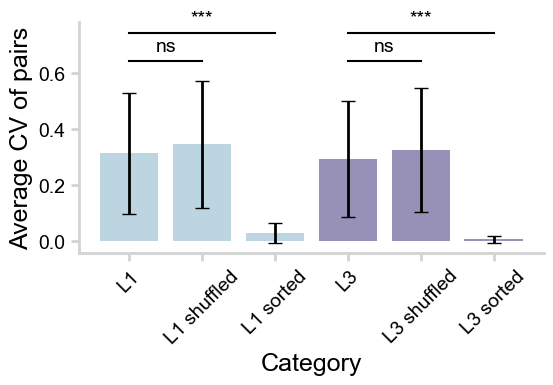

In [ ]:
l1_cvs = all_grouped_pairs_list[0]['CV']
l3_cvs = all_grouped_pairs_list[1]['CV']

# Data
categories = ['L1', 'L1 shuffled', 'L1 sorted', 'L3', 'L3 shuffled', 'L3 sorted']
means = [mean_CV_l1, mean_CV_shuffled_l1, mean_CV_structure_l1, 
         mean_CV_l3, mean_CV_shuffled_l3, mean_CV_structure_l3]
stds = [std_CV_L1, std_CV_shuffled_l1, std_CV_structure_l1,
        std_CV_L3, std_CV_shuffled_l3, std_CV_structure_l3]

df = pd.DataFrame({'Category': categories, 'Mean CV': means, 'Std': stds})

# Bar plot with Seaborn
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(data=df, x='Category', y='Mean CV', ci=None,
            palette=['#97c7dd', '#97c7dd', '#97c7dd', '#645aa3', '#645aa3', '#645aa3'], alpha=0.7)

# Add error bars manually using Matplotlib
ax.errorbar(x=np.arange(len(categories)), y=means, yerr=stds, fmt='none', capsize=5, color='black')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.ylabel('Average CV of pairs')

# Set the positions for significance stars
x1, x2 = 0, 1   # Positions of the groups (x-axis)
y, h, col = l1_cvs.max() + 0.3, 0.001, 'k'  # y position, height, and color
# Add lines and significance stars
ax1.plot([x1, x2], [y, y], lw=1.5, color=col)         # Horizontal line between the groups
ax1.text((x1 + x2) * 0.5, y + h, helper.get_significance_star(p_value), ha='center', va='bottom', color=col, fontsize=14)

# Set significance comparisons and positions
comparisons = [
        (0, 1),  # L1 vs L1 shuffled
        (0, 2),  # L1 vs L1 sorted
        (3, 4),  # L3 vs L3 shuffled
        (3, 5)   # L3 vs L3 sorted
]

# Set y position, height, and color for the significance stars
y = max(means) + 0.3
h = 0.02  # Height of the line for the significance bar
col = 'k'  # Color of the significance line

# Loop over comparisons and plot significance lines and labels
for i, (x1, x2) in enumerate(comparisons):
    p_value = corrected_p_values[i]
    print(p_value)
    
    if i % 2 == 0:
        y = max(means) + 0.3
    else:
        y += 0.1
                

    # Add horizontal line for significance
    ax.plot([x1, x2], [y, y], lw=1.5, color=col)  # Horizontal line between the groups
    
    # Add significance stars
    ax.text((x1 + x2) * 0.5, y + h, helper.get_significance_star(p_value), ha='center', va='bottom', color=col, fontsize=14)

# Save the figure
# plt.savefig(path_plots+'Fig2/Fig2G.png')
# plt.savefig(path_plots+'Fig2/Fig2G.svg')

mean_CV_shuffled_l1, mean_CV_shuffled_l3, mean_CV_l1, mean_CV_l3, mean_CV_structure_l1, mean_CV_structure_l3

In [22]:
dual_syn_pairs_const_list[0].CV.mean(), dual_syn_pairs_const_list[1].CV.mean()

(0.4425276362019486, 0.415168306301469)

## Supplementary Figure S1

### Supp. Figure S1 panel A:

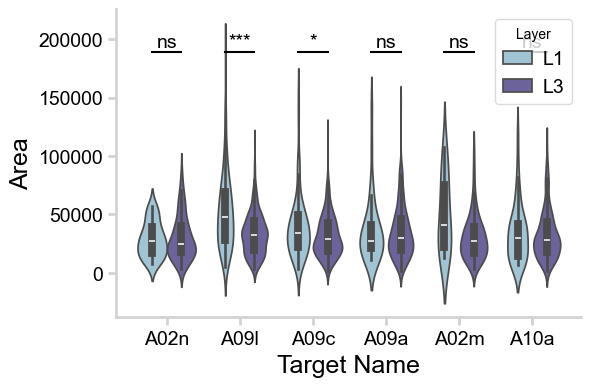

In [ ]:
# Copy and label each dataset
l1_data = l1_connectors.copy()
l3_data = l3_connectors.copy()
l1_data['target_name'] = [c.split('_')[0] for c in l1_data['target_name']]
l3_data['target_name'] = [c.split('_')[0] for c in l3_data['target_name']]
l1_data['source_name'] = [c.split('_')[0] for c in l1_data['source_name']]
l3_data['source_name'] = [c.split('_')[0] for c in l3_data['source_name']]

# Add a label to each dataset for easy distinction in the plot
l1_data['layer'] = 'L1'
l3_data['layer'] = 'L3'

# Concatenate the data for a combined plot
combined_data = pd.concat([l1_data, l3_data])

# Initialize the figure
plt.figure(figsize=(6, 4))

color_dict = {'L1': plot_settings.l1_color, 'L3': plot_settings.l3_color}

# Plot violin plot without splitting
sns.violinplot(data=combined_data, x='target_name', y='area', hue='layer', dodge=True, palette=plot_settings.color_dict)

# Loop over each target group to perform statistical tests and add significance lines
target_groups = combined_data['target_name'].unique()

for i, target in enumerate(target_groups):
    l1_values = combined_data[(combined_data['target_name'] == target) & (combined_data['layer'] == 'L1')]['area']
    l3_values = combined_data[(combined_data['target_name'] == target) & (combined_data['layer'] == 'L3')]['area']
    
    # Perform Mann-Whitney U test
    if not l1_values.empty and not l3_values.empty:
        stat, p_value = mannwhitneyu(l1_values, l3_values, alternative='two-sided')
        # stat, p_value = stats.ttest_ind(l1_values, l3_values)
        
        # Add significance line and label
        y, h, col = combined_data['area'].max(), combined_data['area'].max()/200, 'k'  # line height and color
        plt.plot([i - 0.2, i + 0.2], [y, y], lw=1.5, color=col)  # line above violins
        
        # Add significance text above line
        plt.text(i, y + h, helper.get_significance_star(p_value), ha='center', va='bottom', color=col, fontsize=14)
        
# Customize plot
plt.legend(title='Layer')
plt.xlabel("Target Name")
plt.ylabel("Area")

# # # save the plot
# plt.savefig(path_plots+'FigS1/FigS1A.png')
# plt.savefig(path_plots+'FigS1/FigS1A.svg')